# SIMPLE ROUTING
(compute distance direction and route between two points)

In [1]:
# create folder to save output
import os
# set the basepath - folder containing data and where the ouput will be written
basepath = os.path.join(os.getcwd(), "Output")
os.makedirs(basepath, exist_ok=True)

## 1. Data Preparation
1. combine all points of interest file
2. Create 'place_name' attribute and add the names of all points of interest
3. Remove duplicate place names
4. The places in the final geodataframe will be used for further routing application

In [2]:
import os
import geopandas as gpd
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Data (Points of interest features in Varanasi)
amenity_data = "https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/simplerouting-data/amenity_varanasi.gpkg"
historic_data = "https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/simplerouting-data/shops_varanasi.gpkg"
shops_data = "https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/simplerouting-data/shops_varanasi.gpkg"
tourism_data = "https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/simplerouting-data/tourism_varanasi.gpkg"

In [4]:
# Load the geopackages
amenity_gdf = gpd.read_file(amenity_data)
historic_gdf = gpd.read_file(historic_data)
shops_gdf = gpd.read_file(shops_data)
tourism_gdf = gpd.read_file(tourism_data)

# Combine the geometries using pd.concat
all_points_gdf = pd.concat([amenity_gdf, historic_gdf, shops_gdf, tourism_gdf], ignore_index=True)

# Reproject to EPSG:4326 (WGS 84)
all_points_gdf = all_points_gdf.to_crs(epsg=4326)

print("Merged and converted geopackages to EPSG:4326")

Merged and converted geopackages to EPSG:4326


In [5]:
# Create the new column 'place_name' and fill it with values from 'REMARK' and 'name_en', falling back to 'name'
all_points_gdf['place_name'] = all_points_gdf['name_en'].combine_first(all_points_gdf['name'])

In [6]:
all_points_gdf.head()

,amenity,name_en,name,geometry,shop,tourism,place_name
0,cinema,None,BLW Cinema Hall,POINT (82.96189 25.28626),NaN,NaN,BLW Cinema Hall
1,hospital,None,Mata Anandmayee Hosiptal,POINT (83.00551 25.2929),NaN,NaN,Mata Anandmayee Hosiptal
2,place_of_worship,Sankat Mochan Hanuman Temple (Mandir),संकट मोचन हनुमान मंदिर,POINT (82.99991 25.28199),NaN,NaN,Sankat Mochan Hanuman Temple (Mandir)
3,place_of_worship,None,Baba Keenaram Ashram,POINT (83.00328 25.29589),NaN,NaN,Baba Keenaram Ashram
4,place_of_worship,None,St Marys Church,POINT (82.97945 25.33614),NaN,NaN,St Marys Church


In [7]:
gdf_final = all_points_gdf.drop_duplicates(subset=['place_name'], keep='first')

In [8]:
# Uncomment to view rows 200 to 250 to check if the place name attribute is cleaned up
# gdf_final.iloc[200:250]

## 2. Routing

### 2a. Get start and end point coordinates

- There are 3 options to get start point
    1. Select from Dropdown - select from the list of places in the dropdown. By default the option is disabled, click on other option and select 'drop down radio button.
    2. Get Current Location - selecting this will use location based on your ip address
    3. Select from Map - this option will enable a map to click on the desired location
-  Select drop point from the drop down menu
-  click ok to finalise start and stop location

In [ ]:
import os
import geopandas as gpd
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from shapely.geometry import Point
import requests
import ipyleaflet as ipyl
import time
import warnings

warnings.filterwarnings("ignore")

# Function to get current location via ipinfo
def get_current_location():
    response = requests.get("https://ipinfo.io/json", timeout=5).json()
    lat_str, lon_str = response.get("loc", ",").split(",")
    return float(lat_str), float(lon_str)

# Convert shapely.geometry.Point → (lat, lon)
def coords_to_latlon(point):
    if isinstance(point, Point):
        return (point.y, point.x)
    return None

# ipyleaflet widget for selecting point
_marker = None

def create_ipyleaflet_picker(center_latlon):
    global _marker
    m = ipyl.Map(center=center_latlon, zoom=5,
                 basemap=ipyl.basemaps.OpenStreetMap.Mapnik,
                 scroll_wheel_zoom=True,
                 layout=widgets.Layout(height='400px'))

    _marker = ipyl.Marker(location=center_latlon, draggable=True)
    m.add_layer(_marker)

    info = widgets.HTML("Drag the marker or click on the map to choose your start point.")

    def handle_click(**kwargs):
        if kwargs.get("type") == "click":
            _marker.location = kwargs["coordinates"]

    m.on_interaction(handle_click)

    out_map = widgets.Output()
    with out_map:
        display(m)

    return widgets.VBox([info, out_map])

# ---------------------------------------------------------------
# UI Widgets

end_dropdown = widgets.Dropdown(
    options=gdf_final['place_name'].dropna().unique().tolist(),
    description='End Point:',
    disabled=False,
)

start_method = widgets.RadioButtons(
    options=['Select from Dropdown', 'Get Current Location', 'Select from Map'],
    description='Start Point Method:',
    disabled=False
)

start_dropdown = widgets.Dropdown(
    options=gdf_final['place_name'].dropna().unique().tolist(),
    description='Start Point:',
    disabled=True
)

ok_button = widgets.Button(
    description='OK',
    button_style='success',
)

map_container = widgets.VBox()
output = widgets.Output()

# Debounce logic to prevent multiple rapid clicks

last_click_time = 0

start_coord = None
end_coord = None

# Function called when OK is pressed

def update_coordinates(button):
    global last_click_time
    global start_coord, end_coord, _marker

    # Debounce to avoid multiple rapid clicks
    current_time = time.time()
    if current_time - last_click_time < 0.5:
        return
    last_click_time = current_time

    with output:
        clear_output()

        # Determine start coordinate
        if start_method.value == 'Select from Dropdown':
            start_place = start_dropdown.value
            if start_place:
                start_point = gdf_final.loc[gdf_final['place_name'] == start_place, 'geometry'].values[0]
                start_coord = coords_to_latlon(start_point)
        elif start_method.value == 'Get Current Location':
            start_coord = get_current_location()
        elif start_method.value == 'Select from Map':
            if _marker is None:
                print("No point selected yet.")
                return
            start_coord = tuple(_marker.location)

        # Determine end coordinate
        end_place = end_dropdown.value
        if end_place:
            end_point = gdf_final.loc[gdf_final['place_name'] == end_place, 'geometry'].values[0]
            end_coord = coords_to_latlon(end_point)

        print(f"Start Coordinate: {start_coord}")
        print(f"End Coordinate: {end_coord}")


# Function called when radio button changes

def on_method_change(change):
    selected_method = change.new
    map_container.children = []
    if selected_method == 'Select from Dropdown':
        start_dropdown.disabled = False
    elif selected_method == 'Get Current Location':
        start_dropdown.disabled = True
    elif selected_method == 'Select from Map':
        start_dropdown.disabled = True
        centroid = gdf_final.to_crs("EPSG:4326").geometry.unary_union.centroid
        center_latlon = [centroid.y, centroid.x]
        map_picker = create_ipyleaflet_picker(center_latlon)
        map_container.children = [map_picker]

# Wire up events
start_method.observe(on_method_change, names='value')
ok_button.on_click(update_coordinates)

# Display widgets
display(start_method, start_dropdown, end_dropdown, ok_button, map_container, output)


RadioButtons(description='Start Point Method:', options=('Select from Dropdown', 'Get Current Location', 'Sele…

Dropdown(description='Start Point:', disabled=True, options=('BLW Cinema Hall', 'Mata Anandmayee Hosiptal', 'S…

Dropdown(description='End Point:', options=('BLW Cinema Hall', 'Mata Anandmayee Hosiptal', 'Sankat Mochan Hanu…

Button(button_style='success', description='OK', style=ButtonStyle())

VBox()

Output()

### 2b. Create coordinate list to input to graphhopper API

In [14]:
#create a list to add the coordinates
coordinates_list = []

if start_coord:
    coordinates_list.append(start_coord)

if end_coord:
    coordinates_list.append(end_coord)

# Print the list of coordinates
print("List of coordinates:", coordinates_list)


List of coordinates: [(25.28625570000001, 82.9618939), (25.292902899999998, 83.0055074)]


### 2c. get distance, duration and route between the points using Graphhopper
(create an account in https://www.graphhopper.com/ and add a key - https://graphhopper.com/dashboard/#/apikeys)
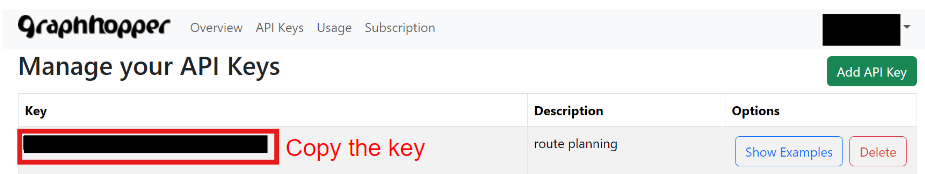

In [ ]:
api_key = ''  # Replace with your GraphHopper API key

In [19]:
from graphh import GraphHopper

# Initialize GraphHopper
gh_client = GraphHopper(api_key=api_key)

distance = gh_client.distance(coordinates_list, unit='km')
print("Distance:" ,distance, "km")
duration = gh_client.duration(coordinates_list, vehicle='car', unit='h')
print("Duration:", duration, "hours (", duration*60, "minutes )")
route = gh_client.route(coordinates_list, request='get', vehicle='car', locale='en', calc_points='true', instructions='true', points_encoded='true', elevation='false')
print("Route response:", route)

Distance: 5.4314610000000005 km
Duration: 0.26633222222222225 hours ( 15.979933333333335 minutes )
Route response: {'hints': {'visited_nodes.sum': 624, 'visited_nodes.average': 624.0}, 'info': {'copyrights': ['GraphHopper', 'OpenStreetMap contributors'], 'took': 2, 'road_data_timestamp': '2025-07-06T18:00:00Z'}, 'paths': [{'distance': 5431.461, 'weight': 1040.267851, 'time': 958796, 'transfers': 0, 'points_encoded': True, 'points_encoded_multiplier': 100000.0, 'bbox': [82.962064, 25.282668, 83.005593, 25.293706], 'points': 'eriyC{ojyNmA}Ie@sCQmBYmB?c@t@{Q@MhCXtCRf@Dh@HJc@LoALuELaBLqA`@eHPcFZgIJoG?YH_DZ{H^{GHkBRoKHm@TcARq@LWa@iAUu@i@uBc@mAgAgDWu@g@gACIKAKEcAo@eAg@o@Y_@Mm@QuFeA]Ks@YeAe@o@G]KeA{@o@c@WOgB]gAMm@M}@Wk@MI_@IYOWW[SYS]O]u@gCq@cB{@eBOQQOiAg@g@Y_As@]]s@g@iAi@s@UXu@Ne@R{@DSFeAL@Fy@GKAWJcA\\yCLYLmBAa@PeELiBV}BAEAEBEJoAFq@@{@AOEUe@uBc@eBECECAGAG@GBEBEFAUyBCwC?a@LmB@g@@o@tAAGC@aAAq@KI', 'instructions': [{'distance': 702.131, 'heading': 76.19, 'sign': 0, 'interval': [0, 7], 'text': 'C

In [17]:
import folium
from folium import IFrame
from IPython.display import display, HTML


# Prepare popup labels

start_label = None
end_label = None

if start_method.value == 'Select from Dropdown':
    start_label = f"Start Point: {start_dropdown.value}"
elif start_method.value == 'Get Current Location':
    start_label = "Start Point: Current Location"
elif start_method.value == 'Select from Map':
    start_label = "Start Point: Selected on Map"

end_label = f"Stop Point: {end_dropdown.value}"


# Extract the encoded polyline from the route response


encoded_polyline = route.get('paths', [{}])[0].get('points', '')

# Polyline decode function

def decode_polyline(polyline_str):
    """Decode a Google Maps encoded polyline into lat/lon tuples."""
    index = 0
    lat = 0
    lng = 0
    coordinates = []
    while index < len(polyline_str):
        b = 0
        shift = 0
        result = 0
        while True:
            b = ord(polyline_str[index]) - 63
            index += 1
            result |= (b & 0x1f) << shift
            shift += 5
            if b < 0x20:
                break
        delta_lat = ~(result >> 1) if result & 1 else result >> 1
        lat += delta_lat
        shift = 0
        result = 0
        while True:
            b = ord(polyline_str[index]) - 63
            index += 1
            result |= (b & 0x1f) << shift
            shift += 5
            if b < 0x20:
                break
        delta_lng = ~(result >> 1) if result & 1 else result >> 1
        lng += delta_lng
        coordinates.append((lat / 1e5, lng / 1e5))
    return coordinates

# Decode the polyline
decoded_points = decode_polyline(encoded_polyline)


# Create Folium map centered on start point
start_point = decoded_points[0]
map_center = [start_point[0], start_point[1]]
m = folium.Map(location=map_center, zoom_start=12)

# Add route polyline to map

folium.PolyLine(
    decoded_points,
    color='blue',
    weight=5,
    opacity=0.8
).add_to(m)

# Create wider popups using IFrame


iframe_start = IFrame(html=start_label, width=250, height=30)
popup_start = folium.Popup(iframe_start, max_width=300)

iframe_end = IFrame(html=end_label, width=250, height=30)
popup_end = folium.Popup(iframe_end, max_width=300)

# Add markers with popups

folium.Marker(
    location=decoded_points[0],
    popup=popup_start,
    icon=folium.Icon(color='green')
).add_to(m)

folium.Marker(
    location=decoded_points[-1],
    popup=popup_end,
    icon=folium.Icon(color='red')
).add_to(m)

# Display map inline
m
